In [1]:
%matplotlib inline

In [2]:
# 1) Wipe out all Python variables
%reset -f
# 2) Force Python’s garbage collector to run
import gc
gc.collect()

import multiprocessing as mp
mp.set_start_method('spawn', force=True)

import importlib
from libs import trades, plots, params, models
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(models)

import math
import pandas as pd
from pandas import Timestamp
import numpy as np

import glob
import datetime as dt
from datetime import datetime

import optuna
from optuna.trial import TrialState
from optuna.importance import get_param_importances
from optuna.visualization.matplotlib import plot_optimization_history

import json
import matplotlib.pyplot as plt
from IPython.display import display, clear_output, update_display, HTML


from tqdm.auto import tqdm

pd.set_option('display.max_columns', None)

import os # Force fully single-threaded
os.environ["OMP_NUM_THREADS"]    = "1"
os.environ["MKL_NUM_THREADS"]    = "1"
os.environ["NUMEXPR_NUM_THREADS"]= "1"

[main] Found existing base CSV: dfs training/GOOGL_base.csv


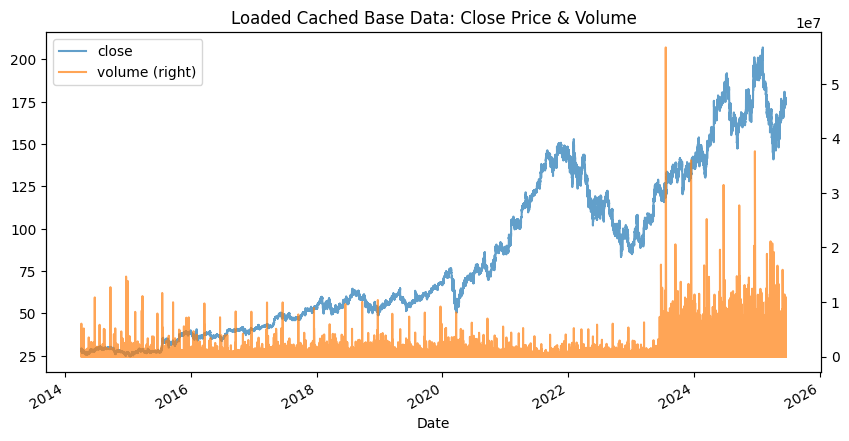

,open,high,low,close,volume,ask,bid
2014-04-03 11:30:00,28.650,28.6500,28.650,28.6500,2000.0,28.658595,28.641405
2014-04-03 11:31:00,28.650,28.6500,28.650,28.6500,2000.0,28.658595,28.641405
2014-04-03 11:32:00,28.650,28.6500,28.650,28.6500,2000.0,28.658595,28.641405
2014-04-03 11:33:00,28.650,28.6500,28.650,28.6500,2000.0,28.658595,28.641405
2014-04-03 11:34:00,28.650,28.6500,28.650,28.6500,2000.0,28.658595,28.641405
...,...,...,...,...,...,...,...
2025-06-18 20:56:00,173.375,173.6771,173.215,173.5650,621199.0,173.617100,173.512900
2025-06-18 20:57:00,173.565,173.5900,173.240,173.3800,624198.0,173.432000,173.328000
2025-06-18 20:58:00,173.390,173.4100,173.200,173.3100,454542.0,173.362000,173.258000
2025-06-18 20:59:00,173.315,173.4000,173.230,173.2800,1094746.0,173.332000,173.228000


In [3]:
ticker         = params.ticker
save_path      = params.save_path

results_folder = "optuna results"              
n_trials = 300
n_jobs = 1

base_csv = os.path.join(save_path, f"{ticker}_base.csv")

if os.path.exists(base_csv):
    # -----------------------------------------------------------------
    # 1) Cached file exists → load it, plot it, skip all processing.
    # -----------------------------------------------------------------
    print(f"[main] Found existing base CSV: {base_csv}")
    df = pd.read_csv(base_csv, index_col=0, parse_dates=True)
    plots.plot_close_volume(
        df,
        title="Loaded Cached Base Data: Close Price & Volume"
    )

else:
    # -----------------------------------------------------------------
    # 2) No cached file → do the full split‐adjust and then minute‐grid prep
    # -----------------------------------------------------------------
    print(f"[main] No base CSV found; running process_splits …")
    df_raw = trades.process_splits(
        folder                   = params.stocks_folder,
        ticker                   = ticker,
        bidasktoclose_spread     = params.bidasktoclose_spread
    )

    # Once‐only minute grid build and interpolation
    print(f"[main] Running prepare_interpolate_data …")
    df = trades.prepare_interpolate_data(
        df                    = df_raw,
        regular_start_shifted = params.regular_start_shifted,
        regular_start         = params.regular_start,
        regular_end           = params.regular_end
    )
    
    # Persist to base CSV and return
    df.to_csv(base_csv)
    print(f"[process_splits] Saved processed data to: {base_csv}")

# df is now guaranteed to be the split‐adjusted, minute‐aligned DataFrame
df


In [4]:
def optimization_function(
    df,
    look_back,
    min_prof_thr, 
    max_down_prop, 
    gain_tightening_factor, 
    merging_retracement_thr, 
    merging_time_gap_thr, 
    smooth_win_sig, 
    pre_entry_decay, 
    short_penalty,
    trailing_stop_thresh,
    buy_threshold
) -> float:
    """
    1) Compute median‐profit reference for this trial's thresholds.
    2) Run full backtest → one Strategy Return ($) per calendar day.
    3) Compute:
        - total_pnl       : sum of daily P&L across all trading days
        - avg_daily_pnl   : total_pnl divided by # of unique trading days
    4) Print both, return avg_daily_pnl to Optuna.
    """
    
    regular_start_pred = dt.time(*divmod(params.regular_start.hour * 60 + params.regular_start.minute - look_back, 60))
    regular_start_shifted = dt.time(*divmod(params.regular_start.hour * 60 + params.regular_start.minute - look_back*2, 60))

    # A) dynamic reference profit (median of all trade profits)
    ref_profit = trades.compute_global_ref_profit(
        df,
        min_prof_thr            = min_prof_thr,
        max_down_prop           = max_down_prop,
        gain_tightening_factor  = gain_tightening_factor,
        merging_retracement_thr = merging_retracement_thr,
        merging_time_gap_thr    = merging_time_gap_thr,
        regular_start_pred      = regular_start_pred,
        regular_end             = params.regular_end
    )

    # B) run backtest, collect one return per day
    simulation = trades.run_trading_pipeline(
        df                       = df,
        col_signal               = 'signal_smooth',
        col_action               = 'signal_action',
        ref_profit               = ref_profit,
        smooth_win_sig           = smooth_win_sig,
        pre_entry_decay          = pre_entry_decay,
        short_penalty            = short_penalty,
        trailing_stop_thresh     = trailing_stop_thresh,
        buy_threshold            = buy_threshold,
        regular_start_shifted    = regular_start_shifted
    )

    # C) extract daily P&L values
    daily_returns = [
        stats['Strategy Return ($)'] 
        for _, (_, _, stats) in simulation.items()
    ]
    total_pnl = float(np.sum(daily_returns))

    # D) compute average daily P&L (zero‐trade days count as $0)
    trading_days   = df.index.normalize().unique()
    num_trading_days = len(trading_days)
    avg_daily_pnl = total_pnl / num_trading_days if num_trading_days else 0.0

    # E) report & cleanup
    print(f"→ Total P&L across {num_trading_days} days: ${total_pnl:.2f}")
    print(f"→ Average daily P&L             : ${avg_daily_pnl:.4f}\n")

    del simulation, daily_returns
    gc.collect()

    return avg_daily_pnl


In [5]:
def objective(trial):
    # 1) sample everything into a dict
    hyperpars = {
        "look_back"               : trial.suggest_categorical("look_back", [30,60,90,180]),
        "min_prof_thr"            : trial.suggest_float("min_prof_thr", 0.1, 1),
        "max_down_prop"           : trial.suggest_float("max_down_prop", 0.1, 0.9),
        "gain_tightening_factor"  : trial.suggest_float("gain_tightening_factor", 0.1, 1),
        "merging_retracement_thr" : trial.suggest_float("merging_retracement_thr", 0.1, 1),
        "merging_time_gap_thr"    : trial.suggest_float("merging_time_gap_thr", 0.1, 1),
        "smooth_win_sig"          : trial.suggest_categorical("smooth_win_sig", [1,2,3,5,10,15,45,60,90,120,180,240]),
        "pre_entry_decay"         : trial.suggest_float("pre_entry_decay", 0.01, 0.5),
        "short_penalty"           : trial.suggest_float("short_penalty", 0.05, 0.75),
        "trailing_stop_thresh"    : trial.suggest_float("trailing_stop_thresh", 0.05, 0.75),
        "buy_threshold"           : trial.suggest_float("buy_threshold", 0.05, 0.75),
    }

    # 2) Log the values for this trial
    print(f"\n▶ Trial {trial.number} Hyperparameters:")
    for name, val in hyperpars.items():
        print(f"    {name:30s} = {val}")
    print()

    # 3) Run the backtest & optimization function
    #    This will print Total P&L and Average Daily P&L,
    #    and return `avg_daily_pnl` for Optuna to maximize.
    avg_daily_pnl = optimization_function(df=df, **hyperpars)

    return avg_daily_pnl


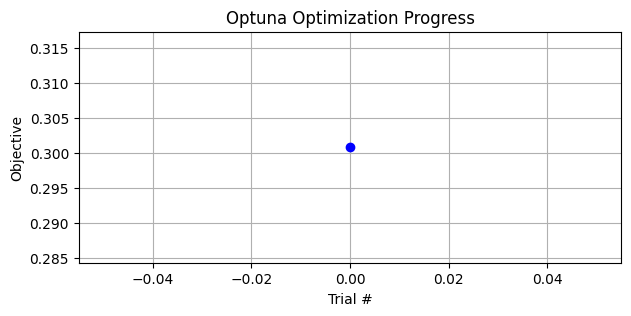

In [6]:
# Build the figure + line ahead of time
fig, ax = plt.subplots(figsize=(7, 3))
line, = ax.plot([], [], "bo-")
ax.set(xlabel="Trial #", ylabel="Objective",
       title="Optuna Optimization Progress")
ax.grid(True)

# Display for update
handle = display(fig, display_id=True)
plt.close(fig)

def live_plot_callback(study, trial):
    xs = [t.number for t in study.trials]
    ys = [t.value  for t in study.trials]
    line.set_data(xs, ys)
    ax.relim()
    ax.autoscale_view()
    handle.update(fig)


In [ ]:
# === Create and Run the Study ===
pruner = optuna.pruners.MedianPruner(n_startup_trials=6, n_warmup_steps=12)

study = optuna.create_study(
    direction="maximize",
    pruner=pruner,
)

def cleanup_cb(study, trial):
    import gc
    gc.collect()

study.optimize(
    objective,
    n_trials=n_trials,
    n_jobs=n_jobs,       # run trials concurrently
    callbacks=[cleanup_cb, live_plot_callback],
    gc_after_trial=True,
)

fig, ax = plt.subplots(figsize=(8, 4))
plot_optimization_history(study, ax)
ax.set_title("Optuna Optimization History")
plt.show()

# === Print Final Results ===
print("Best Parameters:", study.best_params)
print("Best Average Improvement:", study.best_value)

# === Compute & Print Hyperparameter Importances ===
importances = get_param_importances(study)
print("\nHyperparameter importances (higher ⇒ more impact):")
for name, score in sorted(importances.items(), key=lambda x: x[1], reverse=True):
    print(f"  {name:20s} : {score:.3f}")

# ------------------------------------------------------------------
# Build a dynamic file-name .json
# ------------------------------------------------------------------
# 1) Build your session‐only DataFrame once
session_df = df.between_time(params.regular_start,
                             params.regular_end)

# 2) Derive the trading‐day boundaries
first_day = session_df.index.normalize().min()
last_day  = session_df.index.normalize().max()

# 3) Format your file name
start_date = first_day.strftime("%Y%m%d")
end_date   = last_day.strftime("%Y%m%d")
file_name  = f"{ticker}_{start_date}-{end_date}_optuna_signal_pars.json"
file_path  = os.path.join(results_folder, file_name)


# ------------------------------------------------------------------
# Dump study results (including importances)
# ------------------------------------------------------------------
with open(file_path, "w") as f:
    json.dump(
        {
            "best_params":   study.best_params,
            "best_value":    study.best_value,
            "importances":   importances,
            "trials": [
                {
                    "number": t.number,
                    "value":  t.value,
                    "params": t.params,
                    "state":  t.state.name
                }
                for t in study.trials
            ],
        },
        f,
        indent=4,
    )

print(f"\nOptuna results (and importances) saved to: {file_path}")


[I 2025-07-24 15:38:39,168] A new study created in memory with name: no-name-43d1ee02-2957-49ad-b69c-dfb2b39fb89c



▶ Trial 0 Hyperparameters:
    look_back                      = 60
    min_prof_thr                   = 0.3509130613990761
    max_down_prop                  = 0.6885021944086902
    gain_tightening_factor         = 0.14606951685366892
    merging_retracement_thr        = 0.7027381367326334
    merging_time_gap_thr           = 0.11407634881116704
    smooth_win_sig                 = 5
    pre_entry_decay                = 0.3273208835625976
    short_penalty                  = 0.5034281687258491
    trailing_stop_thresh           = 0.714887918423578
    buy_threshold                  = 0.5984237203507853

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-07-24 15:39:21,587] Trial 0 finished with value: 0.3008322695035461 and parameters: {'look_back': 60, 'min_prof_thr': 0.3509130613990761, 'max_down_prop': 0.6885021944086902, 'gain_tightening_factor': 0.14606951685366892, 'merging_retracement_thr': 0.7027381367326334, 'merging_time_gap_thr': 0.11407634881116704, 'smooth_win_sig': 5, 'pre_entry_decay': 0.3273208835625976, 'short_penalty': 0.5034281687258491, 'trailing_stop_thresh': 0.714887918423578, 'buy_threshold': 0.5984237203507853}. Best is trial 0 with value: 0.3008322695035461.


→ Total P&L across 2820 days: $848.35
→ Average daily P&L             : $0.3008


▶ Trial 1 Hyperparameters:
    look_back                      = 30
    min_prof_thr                   = 0.12268935562990368
    max_down_prop                  = 0.5262447637217699
    gain_tightening_factor         = 0.6971397314753375
    merging_retracement_thr        = 0.45745360254904854
    merging_time_gap_thr           = 0.340709455676365
    smooth_win_sig                 = 45
    pre_entry_decay                = 0.0711178266387066
    short_penalty                  = 0.3362445070696408
    trailing_stop_thresh           = 0.35170979370481686
    buy_threshold                  = 0.18871865446991343

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
